In [1]:
import pandas as pd
import numpy as np

from string import punctuation
from nltk.corpus import stopwords as sw
from nltk.tokenize import TweetTokenizer
import nltk
import re
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

FEATURE_LIST = ['created_at', 'id', 'full_text', 'user', 'retweet_count', 'favorite_count', 'coordinates', 'place', 'class']

stopwords = sw.words('english') + ["'d", "'ll", "'re", "'s", "'ve", 'doe', 'ha', "n't", 'sha', 'wa', 'wo']

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
training_set = pd.read_json('development.jsonl', lines=True)
training_set = training_set[FEATURE_LIST]

test_set = pd.read_json('evaluation.jsonl', lines=True)

In [3]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(training_set["full_text"])

X_train = tokenizer.texts_to_sequences(training_set["full_text"])
X_test = tokenizer.texts_to_sequences(test_set["full_text"])

In [9]:
vocabulary_size = len(tokenizer.word_index) + 1

word_count = lambda tweet: len(tweet)
longest_tweet = max(X_train, key=word_count)
len_longest_tweet = len(longest_tweet)
len_longest_tweet

62

In [10]:
from tensorflow.keras.preprocessing import sequence


X_train = sequence.pad_sequences(X_train, maxlen=len_longest_tweet)
X_test = sequence.pad_sequences(X_test, maxlen=len_longest_tweet)

y_train = training_set["class"].to_numpy()

In [12]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.twitter.27B/glove.twitter.27B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocabulary_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
from keras import Sequential
from keras.layers import Embedding, LSTM, SpatialDropout1D, Dropout

embedding_size = 50

model=Sequential()

model.add(Embedding(vocabulary_size, embedding_size, input_length=len_longest_tweet))

model.add(SpatialDropout1D(0.25))

model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))

model.add(Dropout(0.2))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 62, 50)            3334950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 62, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
Total params: 3,395,350
Trainable params: 3,395,350
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
from keras.callbacks import EarlyStopping
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

callback = [EarlyStopping(patience=2)]
batch_size = 64
num_epochs = 10
num_valid = 512

X_valid, y_valid = X_train[:num_valid], y_train[:num_valid]
X_train2, y_train2 = X_train[num_valid:], y_train[num_valid:]

model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs, callbacks=callback)

Epoch 1/10
 148/1242 [==>...........................] - ETA: 2:01 - loss: 3.0169 - accuracy: 0.0048

KeyboardInterrupt: 

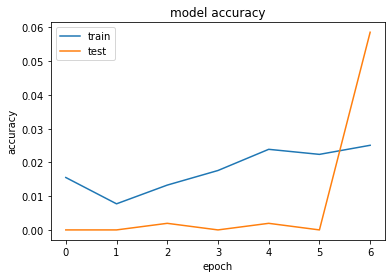

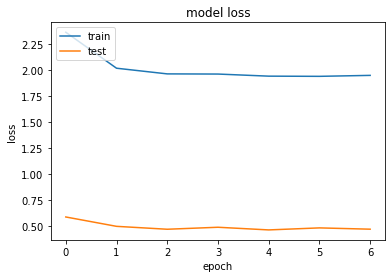

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test)
predictions = np.round(predictions.reshape(-1)).astype(int)
pred = pd.DataFrame()
pred.insert(0, "Predicted", predictions, True)
pred.to_csv('submission_LSTM.csv',sep=',', index_label='Id')
